Total training images: 60000


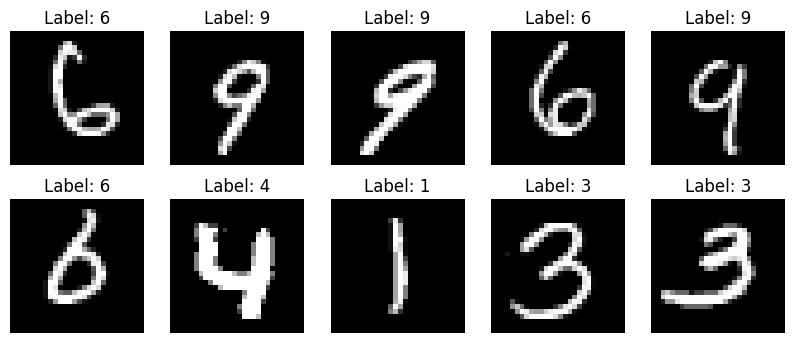

In [3]:
# Install required libraries (if not already installed)
# Import libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset (downloads automatically if not available)
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Print dataset size
print(f"Total training images: {len(dataset)}")

# Show some sample images
def show_samples(dataloader):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(10,4))
    for i in range(10):
        plt.subplot(2,5,i+1)
        img = images[i].squeeze() * 0.5 + 0.5  # unnormalize
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

show_samples(dataloader)


In [5]:
import torch.nn as nn  # Import nn module

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [9]:
import torch.optim as optim  # Correctly import torch.optim


generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)


In [11]:
import numpy as np

epochs = 2
for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.view(batch_size, -1)
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        outputs = discriminator(real_imgs)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, 100)
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, 100)
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs)
        g_loss = criterion(outputs, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
    print(f"Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")


Epoch [1/2], d_loss: 0.8336988687515259, g_loss: 3.7049193382263184
Epoch [2/2], d_loss: 0.7831265330314636, g_loss: 2.9800992012023926


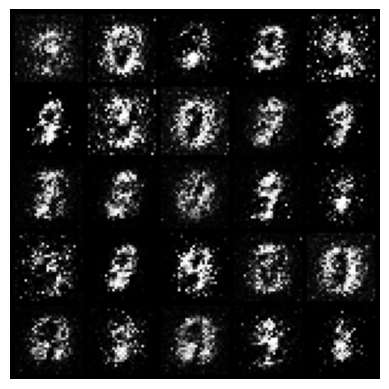

In [12]:
import torchvision  # <-- make sure this is imported

def show_images(generator, n_images=25):
    z = torch.randn(n_images, 100)
    fake_images = generator(z).view(-1, 1, 28, 28)
    grid = torchvision.utils.make_grid(fake_images, nrow=5, normalize=True)
    plt.imshow(np.transpose(grid.cpu(), (1,2,0)))
    plt.axis('off')
    plt.show()

# Call the function
show_images(generator)

